In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    print("CUDA Version:", torch.version.cuda)
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is NOT available.")


CUDA is available!
CUDA Version: 11.8
GPU Name: NVIDIA GeForce RTX 4060 Ti


In [ ]:
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# undestanding

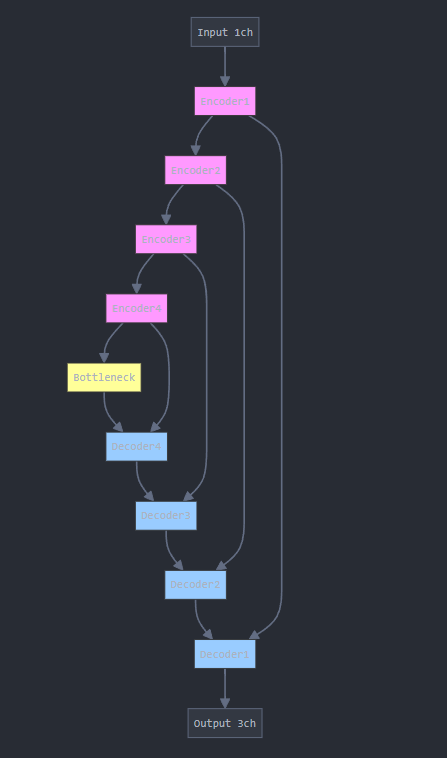
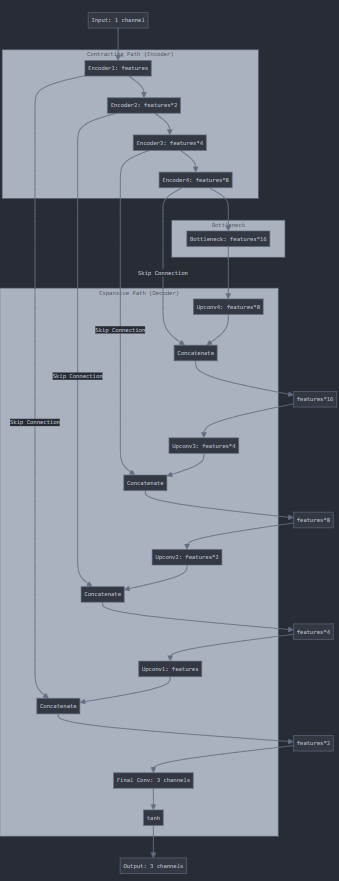

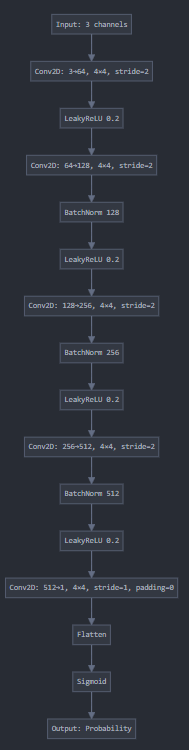

# main

In [1]:
import time
import csv
import subprocess
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#######################################
# 1. Define the U-Net Generator Class #
#######################################
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features=64):
        super(UNetGenerator, self).__init__()
        # Encoder blocks (contracting path)
        self.encoder1 = self.contracting_block(in_channels, features)         # output: features, size: 512 -> 256
        self.encoder2 = self.contracting_block(features, features * 2)          # output: features*2, size: 256 -> 128
        self.encoder3 = self.contracting_block(features * 2, features * 4)        # output: features*4, size: 128 -> 64
        self.encoder4 = self.contracting_block(features * 4, features * 8)        # output: features*8, size: 64 -> 32

        # Bottleneck layer
        self.bottleneck = self.contracting_block(features * 8, features * 16)     # output: features*16, size: 32 -> 16

        # Decoder blocks (expansive path)
        self.upconv4 = self.expansive_block(features * 16, features * 8)          # size: 16 -> 32
        self.upconv3 = self.expansive_block(features * 16, features * 4)          # size: 32 -> 64
        self.upconv2 = self.expansive_block(features * 8, features * 2)           # size: 64 -> 128
        self.upconv1 = self.expansive_block(features * 4, features)               # size: 128 -> 256

        # Final convolution to get the desired output channels
        self.final_conv = nn.Conv2d(features * 2, out_channels, kernel_size=1)

    def contracting_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        """A single contracting block used in the encoder."""
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def expansive_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        """A single expansive block used in the decoder."""
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Encode
        e1 = self.encoder1(x)   # output size: 256x256
        e2 = self.encoder2(e1)  # output size: 128x128
        e3 = self.encoder3(e2)  # output size: 64x64
        e4 = self.encoder4(e3)  # output size: 32x32

        # Bottleneck
        b = self.bottleneck(e4) # output size: 16x16

        # Decode with skip connections
        d4 = self.upconv4(b)            # upsample: 16 -> 32
        d4 = torch.cat([d4, e4], dim=1)   # size remains 32

        d3 = self.upconv3(d4)           # upsample: 32 -> 64
        d3 = torch.cat([d3, e3], dim=1)  # size remains 64

        d2 = self.upconv2(d3)           # upsample: 64 -> 128
        d2 = torch.cat([d2, e2], dim=1)  # size remains 128

        d1 = self.upconv1(d2)           # upsample: 128 -> 256
        d1 = torch.cat([d1, e1], dim=1)  # size remains 256

        out = self.final_conv(d1)       # output size: 256x256

        # Upsample final output from 256x256 to 512x512
        out = nn.functional.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)
        return torch.tanh(out)

#########################################
# 2. Define the CNN Discriminator Class #
#########################################
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer to output a single-channel feature map (patch discriminator)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        out = self.net(x)
        # Flatten output so each element corresponds to a patch's probability
        return torch.sigmoid(out.view(-1))

##################################################
# 3. Define Optional Perceptual Loss using VGG16  #
##################################################
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # Load pretrained VGG16 and use its features up to layer 16
        vgg = models.vgg16(pretrained=True).features
        self.slice = nn.Sequential(*list(vgg[:16])).eval()
        for param in self.slice.parameters():
            param.requires_grad = False
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x_vgg = self.slice(x)
        y_vgg = self.slice(y)
        loss = self.criterion(x_vgg, y_vgg)
        return loss

######################################
# 4. GPU Stats Logging (nvidia-smi)  #
######################################
def get_gpu_stats():
    try:
        # Query GPU memory usage and temperature
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=memory.used,temperature.gpu", "--format=csv,noheader,nounits"],
            stdout=subprocess.PIPE,
            text=True
        )
        output = result.stdout.strip()
        memory_used, temperature = output.split(', ')
        return int(memory_used), int(temperature)
    except Exception as e:
        print("Failed to get GPU stats:", e)
        return None, None

#####################################
# 5. Training Function and Loop     #
#####################################
def train():
    # --------------------
    # Hyperparameters
    # --------------------
    num_epochs = 10
    batch_size = 16  # Changed batch size from 8 to 12
    learning_rate = 0.0002
    lambda_rec = 100   # weight for reconstruction (L1) loss
    lambda_perc = 10   # weight for perceptual loss

    # --------------------
    # Data Preparation
    # --------------------
    data_dir = r"Z:\sumit43336\Python\GAN\archive"  # Update this path to your dataset
    transform = transforms.Compose([
        transforms.Resize((512, 512)),          # Resize images to 512x512
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize images to [-1, 1]
    ])

    # Using ImageFolder - expects images in subfolders
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print("Dataset size:", len(dataset))
    print("Number of batches:", len(dataloader))

    # --------------------
    # Initialize Models
    # --------------------
    generator = UNetGenerator(in_channels=1, out_channels=3).to(device)
    discriminator = Discriminator(in_channels=3).to(device)

    # --------------------
    # Loss Functions
    # --------------------
    adversarial_criterion = nn.BCELoss()  # Binary cross-entropy loss for adversarial loss
    reconstruction_criterion = nn.L1Loss()  # L1 loss for reconstruction
    perceptual_criterion = PerceptualLoss().to(device)  # Perceptual loss using VGG16 features

    # --------------------
    # Optimizers and Schedulers
    # --------------------
    optimizer_G = optim.AdamW(generator.parameters(), lr=learning_rate)
    optimizer_D = optim.AdamW(discriminator.parameters(), lr=learning_rate)
    scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=num_epochs)
    scheduler_D = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=num_epochs)

    # --------------------
    # CSV Logging Setup
    # --------------------
    csv_file = r"Z:\sumit43336\Python\GAN\GANproject\training_metrics.csv"
    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Gen Loss", "Disc Loss", "Disc Accuracy", "Epoch Time (s)", "GPU Memory (MiB)", "GPU Temp (°C)"])

    total_training_start = time.time()

    # --------------------
    # Training Loop
    # --------------------
    for epoch in range(1, num_epochs + 1):
        print(f"Starting epoch {epoch}")
        epoch_start = time.time()
        gen_loss_epoch = 0.0
        disc_loss_epoch = 0.0
        correct_disc = 0
        total_disc = 0

        for batch_idx, (imgs, _) in enumerate(dataloader, 1):
            # Move images to device
            imgs = imgs.to(device)
            # Create grayscale images for generator input using weighted sum of channels
            imgs_gray = 0.2989 * imgs[:, 0:1, :, :] + 0.5870 * imgs[:, 1:2, :, :] + 0.1140 * imgs[:, 2:3, :, :]

            # --------------
            # Train Generator
            # --------------
            optimizer_G.zero_grad()
            gen_imgs = generator(imgs_gray)
            pred_fake = discriminator(gen_imgs)
            valid = torch.ones_like(pred_fake, device=device)
            loss_G_adv = adversarial_criterion(pred_fake, valid)
            loss_G_rec = reconstruction_criterion(gen_imgs, imgs)
            loss_G_perc = perceptual_criterion(gen_imgs, imgs)
            loss_G = loss_G_adv + lambda_rec * loss_G_rec + lambda_perc * loss_G_perc
            loss_G.backward()
            optimizer_G.step()

            # --------------
            # Train Discriminator
            # --------------
            optimizer_D.zero_grad()
            pred_real = discriminator(imgs)
            valid_real = torch.ones_like(pred_real, device=device)
            fake = torch.zeros_like(pred_fake, device=device)
            loss_D_real = adversarial_criterion(pred_real, valid_real)
            pred_fake = discriminator(gen_imgs.detach())
            loss_D_fake = adversarial_criterion(pred_fake, fake)
            loss_D = (loss_D_real + loss_D_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            # Update discriminator accuracy metric (patch-level accuracy)
            correct_disc += ((pred_real > 0.5).float().sum().item() + (pred_fake < 0.5).float().sum().item())
            total_disc += (pred_real.numel() + pred_fake.numel())

            gen_loss_epoch += loss_G.item()
            disc_loss_epoch += loss_D.item()

            # Print batch metrics every 50 batches
            if batch_idx % 1 == 0:
                print(f"Epoch {epoch} Batch {batch_idx}/{len(dataloader)}: "
                      f"Gen Loss = {loss_G.item():.4f}, Disc Loss = {loss_D.item():.4f}")

        scheduler_G.step()
        scheduler_D.step()

        avg_gen_loss = gen_loss_epoch / len(dataloader)
        avg_disc_loss = disc_loss_epoch / len(dataloader)
        avg_disc_accuracy = (correct_disc / total_disc) * 100

        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start

        gpu_memory, gpu_temp = get_gpu_stats()

        with open(csv_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([epoch, avg_gen_loss, avg_disc_loss, avg_disc_accuracy, epoch_time, gpu_memory, gpu_temp])

        print(f"Epoch {epoch}: Gen Loss = {avg_gen_loss:.4f}, Disc Loss = {avg_disc_loss:.4f}, "
              f"Disc Acc = {avg_disc_accuracy:.2f}%, Time = {epoch_time:.2f}s, "
              f"GPU Memory = {gpu_memory} MiB, GPU Temp = {gpu_temp}°C")

    total_training_time = time.time() - total_training_start
    print(f"Total Training Time: {total_training_time:.2f} seconds")

if __name__ == "__main__":
    train()


Dataset size: 3980
Number of batches: 249


z:\sumit43336\venv310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
z:\sumit43336\venv310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 1
Epoch 1 Batch 1/249: Gen Loss = 67.8148, Disc Loss = 0.7139
Epoch 1 Batch 2/249: Gen Loss = 53.8662, Disc Loss = 0.8660
Epoch 1 Batch 3/249: Gen Loss = 48.8950, Disc Loss = 0.7442
Epoch 1 Batch 4/249: Gen Loss = 41.5653, Disc Loss = 0.6848
Epoch 1 Batch 5/249: Gen Loss = 41.6624, Disc Loss = 0.7001
Epoch 1 Batch 6/249: Gen Loss = 40.9220, Disc Loss = 0.6800
Epoch 1 Batch 7/249: Gen Loss = 41.0234, Disc Loss = 0.6839
Epoch 1 Batch 8/249: Gen Loss = 39.4914, Disc Loss = 0.6687
Epoch 1 Batch 9/249: Gen Loss = 36.7940, Disc Loss = 0.6708
Epoch 1 Batch 10/249: Gen Loss = 40.3203, Disc Loss = 0.6722
Epoch 1 Batch 11/249: Gen Loss = 41.3688, Disc Loss = 0.6526
Epoch 1 Batch 12/249: Gen Loss = 38.8602, Disc Loss = 0.6456
Epoch 1 Batch 13/249: Gen Loss = 37.1081, Disc Loss = 0.6374
Epoch 1 Batch 14/249: Gen Loss = 36.0792, Disc Loss = 0.6482
Epoch 1 Batch 15/249: Gen Loss = 37.4141, Disc Loss = 0.6347
Epoch 1 Batch 16/249: Gen Loss = 35.6719, Disc Loss = 0.6101
Epoch 1 Batch 17

In [3]:
import torch
# from train import UNetGenerator, Discriminator  # Make sure train.py is in the same folder or PYTHONPATH

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model architectures
generator = UNetGenerator(in_channels=1, out_channels=3).to(device)
discriminator = Discriminator(in_channels=3).to(device)

# Load the trained models if you have a checkpoint; otherwise, assume the models are already trained.
# For example, if you have a checkpoint file from training, you can load it like this:
# checkpoint = torch.load("checkpoint_epoch_10.pth", map_location=device)
# generator.load_state_dict(checkpoint["generator_state_dict"])
# discriminator.load_state_dict(checkpoint["discriminator_state_dict"])

# Save the state dictionaries to disk:
torch.save(generator.state_dict(), "generator_final.pth")
torch.save(discriminator.state_dict(), "discriminator_final.pth")

print("Models have been saved as 'generator_final.pth' and 'discriminator_final.pth'.")


Models have been saved as 'generator_final.pth' and 'discriminator_final.pth'.


In [4]:
import torch
# from train import UNetGenerator, Discriminator  # Ensure train.py is in the same folder or PYTHONPATH

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your models (should match your training code)
generator = UNetGenerator(in_channels=1, out_channels=3).to(device)
discriminator = Discriminator(in_channels=3).to(device)

# Assume you've trained your model and have the following optimizer and scheduler objects:
# (If you are resuming from training, load these states from a checkpoint.)
optimizer_G = torch.optim.AdamW(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.AdamW(discriminator.parameters(), lr=0.0002)
scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=10)
scheduler_D = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=10)

# Create a checkpoint dictionary with all the relevant information
checkpoint = {
    "epoch": 10,  # update with the final epoch or current epoch
    "generator_state_dict": generator.state_dict(),
    "discriminator_state_dict": discriminator.state_dict(),
    "optimizer_G_state_dict": optimizer_G.state_dict(),
    "optimizer_D_state_dict": optimizer_D.state_dict(),
    "scheduler_G_state_dict": scheduler_G.state_dict(),
    "scheduler_D_state_dict": scheduler_D.state_dict(),
}

# Save the checkpoint dictionary
torch.save(checkpoint, "checkpoint_final.pth")
print("Checkpoint saved as 'checkpoint_final.pth'.")


Checkpoint saved as 'checkpoint_final.pth'.


# test run

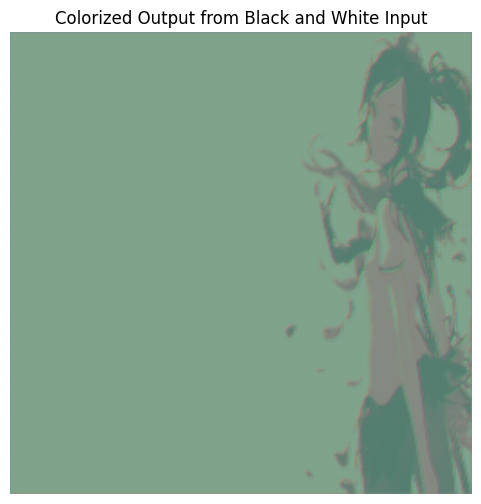

In [8]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Import your UNetGenerator from your training code (ensure train.py is in your PYTHONPATH or same folder)
from generator import UNetGenerator

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 1. Load the Trained Generator Model
# ---------------------------
generator = UNetGenerator(in_channels=1, out_channels=3).to(device)
# Update the checkpoint path to where your model is saved
model_path = "generator_final.pth"
generator.load_state_dict(torch.load(model_path, map_location=device))
generator.eval()  # Set model to evaluation mode

# ---------------------------
# 2. Define Transform for Black and White Image
# ---------------------------
# Since the input image is black and white (1 channel), we use a transform for 1 channel.
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to the expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1 channel
])

# ---------------------------
# 3. Load and Preprocess the Black and White Image
# ---------------------------
# Update the image path to your test image
bw_image_path = r"Z:\sumit43336\Python\GAN\GANproject\wp5303764.jpg"
# bw_image_path = r"Z:\sumit43336\Python\GAN\GANproject\anime-girls-city-monochrome-wallpaper-preview.jpg"
# Load the image and convert it to grayscale (if not already)
bw_image = Image.open(bw_image_path).convert("L")
# Apply the transform and add a batch dimension
bw_tensor = transform(bw_image).unsqueeze(0).to(device)  # Shape: [1, 1, 512, 512]

# ---------------------------
# 4. Run Inference
# ---------------------------
with torch.no_grad():
    colorized_output = generator(bw_tensor)

# The generator outputs a 3-channel image. Denormalize from [-1, 1] to [0, 1]
colorized_output = (colorized_output + 1) / 2

# ---------------------------
# 5. Visualize the Result
# ---------------------------
grid = vutils.make_grid(colorized_output, nrow=1)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title("Colorized Output from Black and White Input")
plt.axis("off")
plt.show()


# new

In [17]:
import time
import csv
import subprocess
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#######################################
# 1. Define the U-Net Generator Class #
#######################################
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features=64):
        super(UNetGenerator, self).__init__()
        # Encoder blocks (contracting path)
        self.encoder1 = self.contracting_block(in_channels, features)         # output: features, size: 512 -> 256
        self.encoder2 = self.contracting_block(features, features * 2)          # output: features*2, size: 256 -> 128
        self.encoder3 = self.contracting_block(features * 2, features * 4)        # output: features*4, size: 128 -> 64
        self.encoder4 = self.contracting_block(features * 4, features * 8)        # output: features*8, size: 64 -> 32

        # Bottleneck layer
        self.bottleneck = self.contracting_block(features * 8, features * 16)     # output: features*16, size: 32 -> 16

        # Decoder blocks (expansive path)
        self.upconv4 = self.expansive_block(features * 16, features * 8)          # size: 16 -> 32
        self.upconv3 = self.expansive_block(features * 16, features * 4)          # size: 32 -> 64
        self.upconv2 = self.expansive_block(features * 8, features * 2)           # size: 64 -> 128
        self.upconv1 = self.expansive_block(features * 4, features)               # size: 128 -> 256

        # Final convolution to get the desired output channels
        self.final_conv = nn.Conv2d(features * 2, out_channels, kernel_size=1)

    def contracting_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        """A single contracting block used in the encoder."""
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def expansive_block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        """A single expansive block used in the decoder."""
        block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, x):
        # Encode
        e1 = self.encoder1(x)   # output size: 256x256
        e2 = self.encoder2(e1)  # output size: 128x128
        e3 = self.encoder3(e2)  # output size: 64x64
        e4 = self.encoder4(e3)  # output size: 32x32

        # Bottleneck
        b = self.bottleneck(e4) # output size: 16x16

        # Decode with skip connections
        d4 = self.upconv4(b)            # upsample: 16 -> 32
        d4 = torch.cat([d4, e4], dim=1)   # size remains 32

        d3 = self.upconv3(d4)           # upsample: 32 -> 64
        d3 = torch.cat([d3, e3], dim=1)  # size remains 64

        d2 = self.upconv2(d3)           # upsample: 64 -> 128
        d2 = torch.cat([d2, e2], dim=1)  # size remains 128

        d1 = self.upconv1(d2)           # upsample: 128 -> 256
        d1 = torch.cat([d1, e1], dim=1)  # size remains 256

        out = self.final_conv(d1)       # size: 256x256

        # Upsample final output from 256x256 to 512x512
        out = nn.functional.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)
        return torch.tanh(out)

#########################################
# 2. Define the CNN Discriminator Class #
#########################################
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer to output a single-channel feature map (patch discriminator)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        out = self.net(x)
        # Flatten output so each element corresponds to a patch's probability
        return torch.sigmoid(out.view(-1))

##################################################
# 3. Define Optional Perceptual Loss using VGG16  #
##################################################
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # Load pretrained VGG16 and use its features up to layer 16
        vgg = models.vgg16(pretrained=True).features
        self.slice = nn.Sequential(*list(vgg[:16])).eval()
        for param in self.slice.parameters():
            param.requires_grad = False
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x_vgg = self.slice(x)
        y_vgg = self.slice(y)
        loss = self.criterion(x_vgg, y_vgg)
        return loss

######################################
# 4. GPU Stats Logging (nvidia-smi)  #
######################################
def get_gpu_stats():
    try:
        # Query GPU memory usage and temperature
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=memory.used,temperature.gpu", "--format=csv,noheader,nounits"],
            stdout=subprocess.PIPE,
            text=True
        )
        output = result.stdout.strip()
        memory_used, temperature = output.split(', ')
        return int(memory_used), int(temperature)
    except Exception as e:
        print("Failed to get GPU stats:", e)
        return None, None

#####################################
# 5. Training Function and Loop     #
#####################################
def train():
    # --------------------
    # Hyperparameters
    # --------------------
    num_epochs = 10
    batch_size = 8
    learning_rate = 0.0002
    lambda_rec = 100   # weight for reconstruction (L1) loss
    lambda_perc = 10   # weight for perceptual loss

    # --------------------
    # Data Preparation
    # --------------------
    data_dir = r"Z:\sumit43336\Python\GAN\archive"  # Update this path to your dataset
    transform = transforms.Compose([
        transforms.Resize((512, 512)),          # Resize images to 512x512
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize images to [-1, 1]
    ])

    # Using ImageFolder - expects images in subfolders
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print("Dataset size:", len(dataset))
    print("Number of batches:", len(dataloader))

    # --------------------
    # Initialize Models
    # --------------------
    generator = UNetGenerator(in_channels=1, out_channels=3).to(device)
    discriminator = Discriminator(in_channels=3).to(device)

    # --------------------
    # Loss Functions
    # --------------------
    adversarial_criterion = nn.BCELoss()  # Binary cross-entropy loss for adversarial loss
    reconstruction_criterion = nn.L1Loss()  # L1 loss for reconstruction
    perceptual_criterion = PerceptualLoss().to(device)  # Perceptual loss using VGG16 features

    # --------------------
    # Optimizers and Schedulers
    # --------------------
    optimizer_G = optim.AdamW(generator.parameters(), lr=learning_rate)
    optimizer_D = optim.AdamW(discriminator.parameters(), lr=learning_rate)
    scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=num_epochs)
    scheduler_D = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=num_epochs)

    # --------------------
    # CSV Logging Setup
    # --------------------
    csv_file = r"Z:\sumit43336\Python\GAN\GANproject\training_metrics.csv"
    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Gen Loss", "Disc Loss", "Disc Accuracy", "Epoch Time (s)", "GPU Memory (MiB)", "GPU Temp (°C)"])

    total_training_start = time.time()

    # --------------------
    # Training Loop
    # --------------------
    for epoch in range(1, num_epochs + 1):
        print(f"Starting epoch {epoch}")
        epoch_start = time.time()
        gen_loss_epoch = 0.0
        disc_loss_epoch = 0.0
        correct_disc = 0
        total_disc = 0

        for i, (imgs, _) in enumerate(dataloader):
            # Move images to device
            imgs = imgs.to(device)
            # Create grayscale images for generator input using weighted sum of channels
            imgs_gray = 0.2989 * imgs[:, 0:1, :, :] + 0.5870 * imgs[:, 1:2, :, :] + 0.1140 * imgs[:, 2:3, :, :]

            # --------------
            # Train Generator
            # --------------
            optimizer_G.zero_grad()
            gen_imgs = generator(imgs_gray)
            pred_fake = discriminator(gen_imgs)
            valid = torch.ones_like(pred_fake, device=device)
            loss_G_adv = adversarial_criterion(pred_fake, valid)
            loss_G_rec = reconstruction_criterion(gen_imgs, imgs)
            loss_G_perc = perceptual_criterion(gen_imgs, imgs)
            loss_G = loss_G_adv + lambda_rec * loss_G_rec + lambda_perc * loss_G_perc
            loss_G.backward()
            optimizer_G.step()

            # --------------
            # Train Discriminator
            # --------------
            optimizer_D.zero_grad()
            pred_real = discriminator(imgs)
            valid_real = torch.ones_like(pred_real, device=device)
            fake = torch.zeros_like(pred_fake, device=device)
            loss_D_real = adversarial_criterion(pred_real, valid_real)
            pred_fake = discriminator(gen_imgs.detach())
            loss_D_fake = adversarial_criterion(pred_fake, fake)
            loss_D = (loss_D_real + loss_D_fake) / 2
            loss_D.backward()
            optimizer_D.step()

            # Update discriminator accuracy metric (patch-level accuracy)
            correct_disc += ((pred_real > 0.5).float().sum().item() + (pred_fake < 0.5).float().sum().item())
            total_disc += (pred_real.numel() + pred_fake.numel())

            gen_loss_epoch += loss_G.item()
            disc_loss_epoch += loss_D.item()

        scheduler_G.step()
        scheduler_D.step()

        avg_gen_loss = gen_loss_epoch / len(dataloader)
        avg_disc_loss = disc_loss_epoch / len(dataloader)
        avg_disc_accuracy = (correct_disc / total_disc) * 100

        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start

        gpu_memory, gpu_temp = get_gpu_stats()

        with open(csv_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([epoch, avg_gen_loss, avg_disc_loss, avg_disc_accuracy, epoch_time, gpu_memory, gpu_temp])

        print(f"Epoch {epoch}: Gen Loss = {avg_gen_loss:.4f}, Disc Loss = {avg_disc_loss:.4f}, "
              f"Disc Acc = {avg_disc_accuracy:.2f}%, Time = {epoch_time:.2f}s, "
              f"GPU Memory = {gpu_memory} MiB, GPU Temp = {gpu_temp}°C")

    total_training_time = time.time() - total_training_start
    print(f"Total Training Time: {total_training_time:.2f} seconds")

if __name__ == "__main__":
    train()


Dataset size: 3980
Number of batches: 498
Starting epoch 1


KeyboardInterrupt: 

# tests

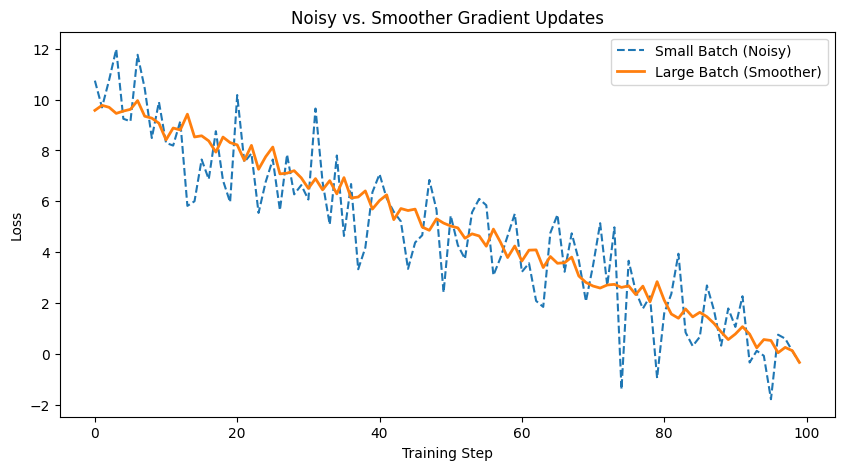

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
steps = np.arange(100)
# Simulated "true" loss decreasing over time
true_loss = np.linspace(10, 0, 100)

# Simulate loss with noise:
# Small batch: higher noise (more jagged updates)
small_batch_loss = true_loss + np.random.normal(0, 1.5, 100)
# Large batch: lower noise (smoother updates)
large_batch_loss = true_loss + np.random.normal(0, 0.3, 100)

plt.figure(figsize=(10, 5))
plt.plot(steps, small_batch_loss, label="Small Batch (Noisy)", linestyle='--')
plt.plot(steps, large_batch_loss, label="Large Batch (Smoother)", linewidth=2)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Noisy vs. Smoother Gradient Updates")
plt.legend()
plt.show()
